In [52]:
# AI Image Detector
# Cameron Kelly

In [53]:
# Getting Data
# https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset/data?select=train_data
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'ai-vs-human-generated-dataset' dataset.
Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset
['test_data_v2', 'train.csv', 'test.csv', 'train_data']


In [54]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Simple Model Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, BatchNormalization, GlobalAveragePooling2D

from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

# For Heat Map
from tensorflow.keras.preprocessing import image
import cv2
import random

In [55]:
# Preparing Data

seed = 42

train_csv = os.path.join(path, "train.csv")
train_img_folder = os.path.join(path, "train_data")

df_train = pd.read_csv(train_csv)
df_train["filepath"] = df_train["file_name"].apply(lambda x: os.path.join(path, x))

# 70/10/20 Training/Validation/Testing Split
X_val, X_test, y_val, y_test = train_test_split(
    df_train["filepath"], df_train["label"],
    test_size = 0.2, stratify = df_train["label"], random_state = seed
)

X_train, X_val, y_train, y_val = train_test_split(
    X_val, y_val,
    test_size = 0.125, stratify = y_val, random_state = seed
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 55965
Validation size: 7995
Test size: 15990


In [56]:
# Preprocessing Data

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img, label

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls = tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls = tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
test_ds = test_ds.map(load_and_preprocess)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

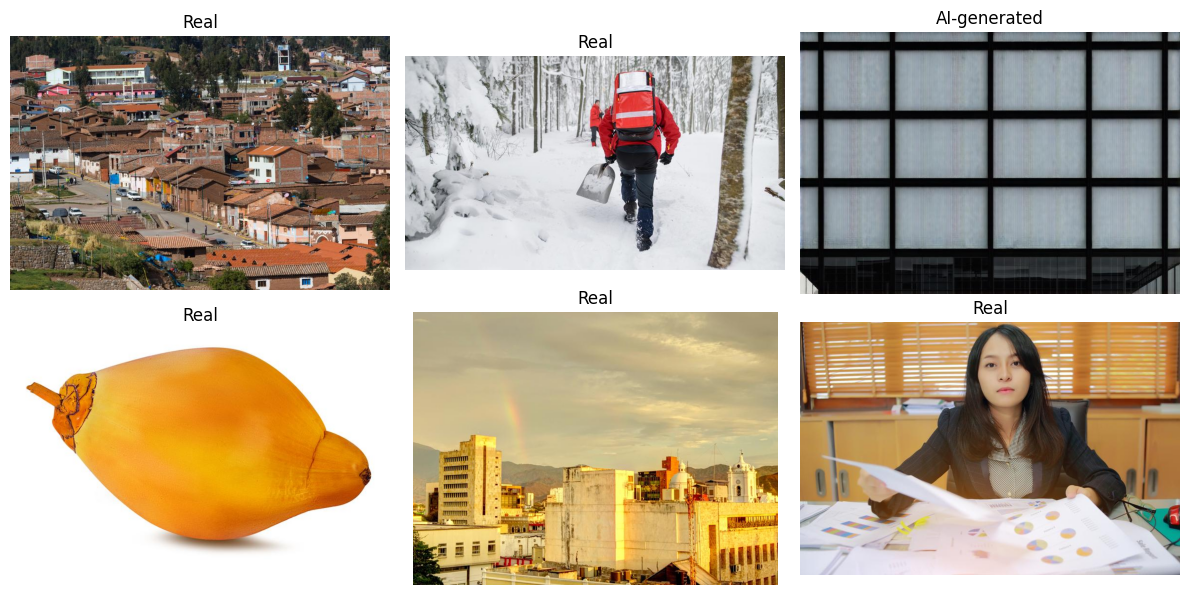

In [57]:
# Visualizing A Few Images

# 0 = Real, 1 = AI-Generated

import matplotlib.image as mpimg
import random

label_dict = {0: "Real", 1: "AI-generated"}

sample_indices = random.sample(range(len(X_train)), 6)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(sample_indices):
    img_path = X_train.iloc[idx]
    label = y_train.iloc[idx]

    img = mpimg.imread(img_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(str(label_dict[label]))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [58]:
# Baseline Model (Simple CNN)

simple_model = Sequential([
    Rescaling(1./255, input_shape = (224, 224, 3)),

    # First Convolution Block
    Conv2D(32, (3, 3), activation = "relu"),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation = "relu"),
    MaxPooling2D(2,2),

    # Second Convolution Block
    Conv2D(64, (3, 3), activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D(2,2),

    # Third Convolution Block
    Conv2D(128, (3, 3), activation = "relu"),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),

    # Fourth Convolution Block
    Conv2D(256, (3, 3), activation = "relu"),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),

    # Global Pooling
    GlobalAveragePooling2D(),

    # Classifier
    Dense(512, activation = "relu"),
    Dropout(0.5),
    Dense(256, activation = "relu"),
    Dropout(0.3),
    Dense(1, activation = "sigmoid")
])

simple_model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [59]:
# Training Simple Model

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True,
    verbose = 1
)

history = simple_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
    shuffle = True,
    callbacks = [early_stop]
)

loss, accuracy = simple_model.evaluate(test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 308s 168ms/step - accuracy: 0.8601 - loss: 0.3474 - val_accuracy: 0.6956 - val_loss: 0.5889
Epoch 2/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 269s 152ms/step - accuracy: 0.9148 - loss: 0.2283 - val_accuracy: 0.9001 - val_loss: 0.2610
Epoch 3/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 268s 152ms/step - accuracy: 0.9257 - loss: 0.2026 - val_accuracy: 0.8363 - val_loss: 0.4127
Epoch 4/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 270s 153ms/step - accuracy: 0.9320 - loss: 0.1795 - val_accuracy: 0.7789 - val_loss: 0.6025
Epoch 5/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 270s 153ms/step - accuracy: 0.9371 - loss: 0.1673 - val_accuracy: 0.8439 - val_loss: 0.4163
Epoch 6/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 335s 160ms/step - accuracy: 0.9432 - loss: 0.1547 - val_accuracy: 0.9062 - val_loss: 0.2508
Epoch 7/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 278s 157ms/step - accuracy: 0.9470 - loss: 0.1422 - val_accuracy: 0.3796 - val_loss: 1.3687
Epoch 8/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 292s 165ms/step - ac

In [60]:
# Save Simple Model
simple_model.save("/content/drive/My Drive/simple_model.h5")

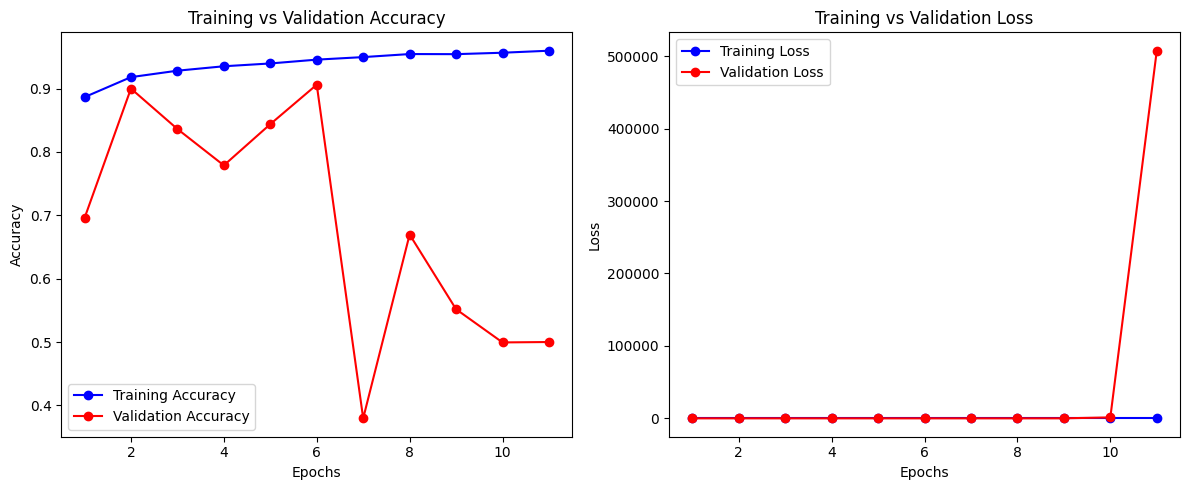

In [61]:
# Plot Accuracy and Loss

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "bo-", label = "Training Accuracy")
plt.plot(epochs, val_acc, "ro-", label = "Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo-", label = "Training Loss")
plt.plot(epochs, val_loss, "ro-", label = "Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step
              precision    recall  f1-score   support

        Real       0.90      0.92      0.91      7995
      AI-Gen       0.91      0.90      0.91      7995

    accuracy                           0.91     15990
   macro avg       0.91      0.91      0.91     15990
weighted avg       0.91      0.91      0.91     15990



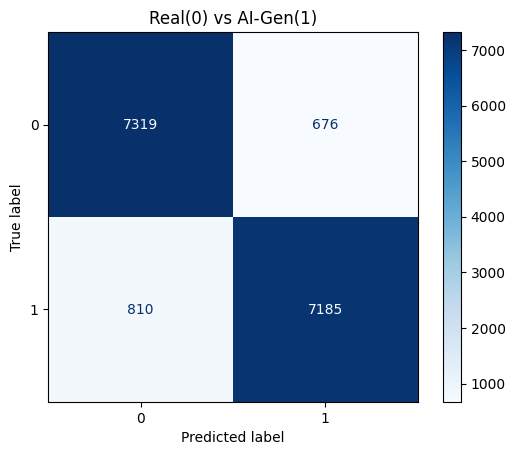

In [62]:
# Classification Report And Confusion Matrix

y_true = np.concatenate([y for x, y in test_ds], axis = 0)

y_pred_probs = simple_model.predict(test_ds)

y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "Blues")
disp.ax_.set_title("Real(0) vs AI-Gen(1)")

# Classification Report
print(classification_report(y_true, y_pred, target_names = ["Real", "AI-Gen"]))

Random image selected: /kaggle/input/ai-vs-human-generated-dataset/train_data/4fd099fbb5ea4a859cbd5df0d7803856.jpg
Using layer: conv2d_15


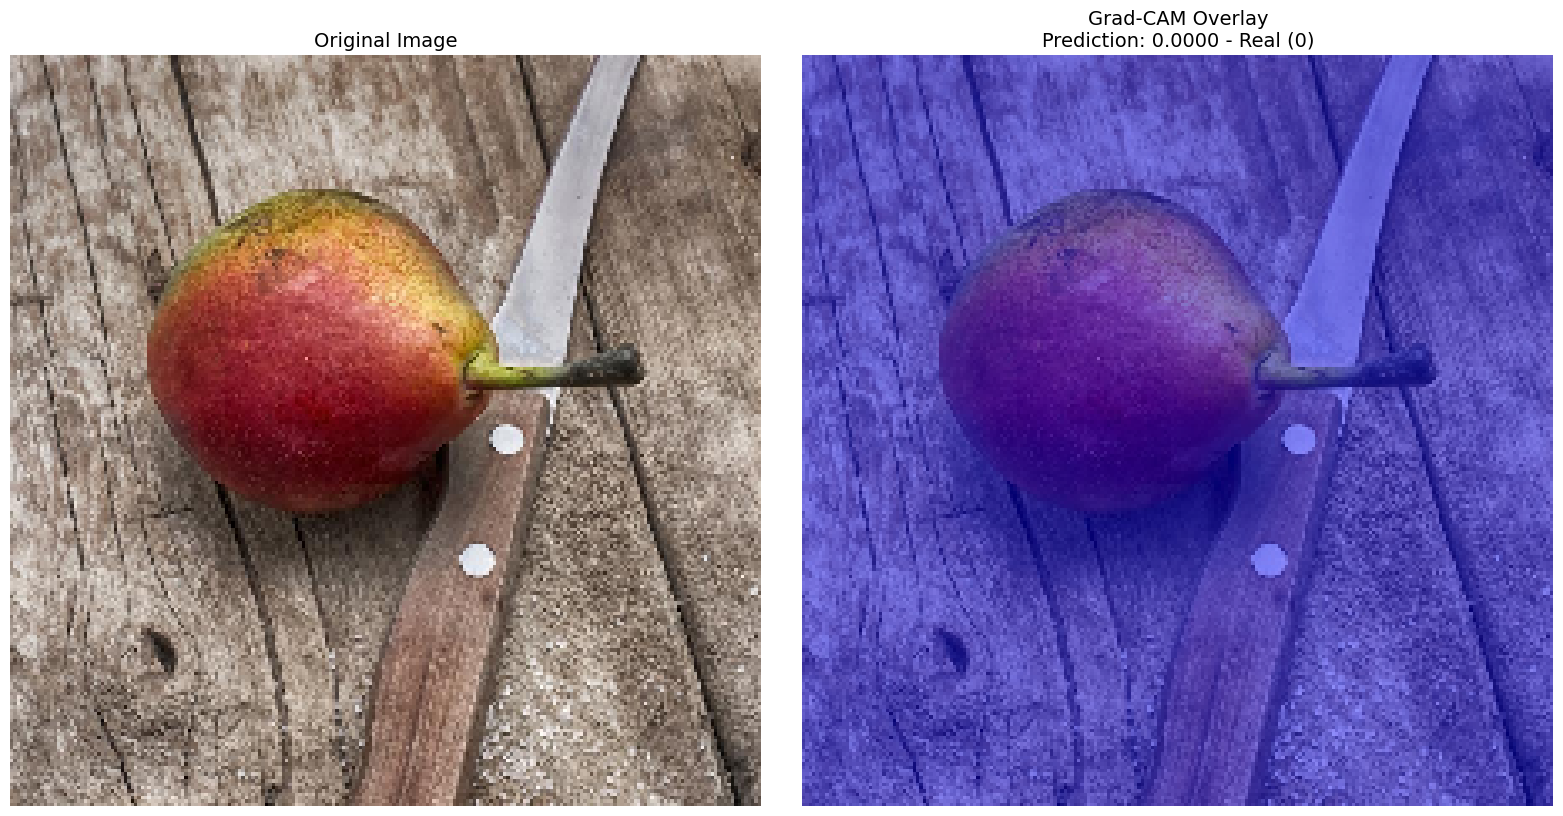

In [165]:
# Visualize Heat Map of Images

# Choose a random image
path = "/kaggle/input/ai-vs-human-generated-dataset/train_data"
all_images = [os.path.join(path, f) for f in os.listdir(path) if f.endswith((".jpg", ".png"))]
img_path = random.choice(all_images)
print("Random image selected:", img_path)

from tensorflow.keras.preprocessing import image


def show_grad_cam(img_path, model, last_conv_layer_name='conv2d_7', alpha=0.8):

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Get the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Create a new model that outputs conv layer activations and predictions
    grad_model = tf.keras.Model(
        [model.inputs],
        [last_conv_layer.output, model.layers[-1].output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Generate heatmap
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap - using ReLU and normalization
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.math.reduce_max(heatmap) + 1e-10)
    heatmap = np.uint8(255 * heatmap.numpy())

    # Colorize heatmap
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((224, 224))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Superimpose
    superimposed = jet_heatmap * alpha + np.array(img)
    superimposed = image.array_to_img(superimposed)

    # Get prediction
    prediction = preds[0][0].numpy()

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=14)
    axes[0].axis('off')

    # Determine predicted class
    predicted_class = "AI-Generated (1)" if prediction >= 0.5 else "Real (0)"

    axes[1].imshow(superimposed)
    axes[1].set_title(f'Grad-CAM Overlay\nPrediction: {prediction:.4f} - {predicted_class}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
# show_grad_cam(img_path, simple_model)
last_conv_layer = None
for layer in reversed(simple_model.layers):
    if 'conv2d' in layer.name:
        last_conv_layer = layer.name
        break
print(f"Using layer: {last_conv_layer}")
show_grad_cam(img_path, simple_model, last_conv_layer_name=last_conv_layer)



In [ ]:
# Chameleon Benchmark

# !wget -O Chameleon.zip https://www.dropbox.com/scl/fi/auujmqk4wk3um0qk83qy9/Chameleon.zip?rlkey=2xtl34s33uce0fa3yb2zf4rqw&st=ftfnd8op&dl=0
# !unzip Chameleon.zip


In [166]:
# Load Simple Model

simple_model = tf.keras.models.load_model("/content/drive/My Drive/simple_model.h5")